# Final Analysis March 16
1. For fig2C, I need the weights of feature ranking to classify age without Klotho (i.e. without ch4 and ch11). 
2. For fig2D, rug plot for CD63. Also the mean and variance
3. For fig2E, rug plot for cd81. Also the mean and variance
4. For fig3G, rug plot for Klotho. In this case, add intensity (your values) columns for alt-kl (ch4) and klotho (ch11) and then plot them. Also send me the mean and variance. 
5. For fig3I, linear regression based weights for prediction of klotho. Can you send me two sets of analysis here: prediction of only ch11 and prediction of ch4+ch11 
6. For fig3J, Correlation between cd82 and klotho. I can make this with the sheet you had sent me. 
7. For fig3K, the heat map like thing that you suggested where the rows are all features and columns are age and Klotho. I need numbers (weights?) to work with. 

I think for most analysis, let's consider Klotho intensity to be a sum of alt-kl (ch4) and klotho (ch11). 

In [166]:
% reload_ext autoreload
% autoreload 2
import pandas as pd
from BioAnalysis import BioAnalysis
import numpy as np
from tqdm import tqdm, trange
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import operator 
from collections import OrderedDict
from sklearn.linear_model import RANSACRegressor
from sklearn import preprocessing
from scipy.stats import fisher_exact
from IPython.display import HTML, display
import csv
import sys
# !{sys.executable} -m pip install seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [167]:
db = pd.read_csv('../Amrita_29feb/features.csv')
analysis = BioAnalysis('../Amrita_29feb/')
points = analysis.points

columns = list(db.columns)
db['Index'] = db.Class*10000 + db['Object Number']
db.set_index('Index')
filtered = analysis.getFilteredIndices()
indices = filtered[:,0]*10000 + filtered[:,1]
indices = [int(index) for index in indices]
filtered_db = db.loc[indices,:]
filtered_db.Intensity_MC_Ch02 = points[:,0]
filtered_db.Intensity_MC_Ch07 = points[:,1]
filtered_db.Intensity_MC_Ch11 = points[:,2]
try:
    filtered_db.Intensity_MC_Ch04 = points[:,3]
except:
    pass
filtered_db['Intensity_MC_KL'] = filtered_db.Intensity_MC_Ch04 + filtered_db.Intensity_MC_Ch11
unfiltered_db = filtered_db


In [168]:
data = []
data.append('Class')
data.append('Object Number')
data.append('Area_M01')
data.append('Area_M03')
data.append('Area_M04')
data.append('Area_M06')
data.append('Area_M07')
data.append('Area_M09')
# data.append('Area_M02')
# data.append('Area_M11')
data.append('Aspect Ratio_M01')
data.append('Aspect Ratio_M06')
data.append('Aspect Ratio_M09')
data.append('Modulation_M02_Ch02')
data.append('Modulation_M03_Ch03')
data.append('Modulation_M07_Ch07')
# data.append('Modulation_M04_Ch04')
# data.append('Modulation_M11_Ch11')
data.append('Intensity_MC_Ch02')
data.append('Intensity_MC_Ch07')
# data.append('Intensity_MC_Ch03')
# data.append('Intensity_MC_Ch04')
# data.append('Intensity_MC_Ch11')
data
filtered_db = unfiltered_db[data]
#     if idx%100==0:
#         sys.stdout.write(str(idx) + '\r')
#         sys.stdout.flush()
# print([column for column in filtered_db.columns])

## Fig. 2C: What features can predict age (without ch 04, ch 11)


In [169]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
# X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
# X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,X.shape[1]):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
# sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
# names = list(sorted_d.keys())
# values = list(sorted_d.values())

# df = pd.DataFrame(list(zip(values,names))).set_index(1)

# df.plot.line(rot=90)

features_1 = features

Feature Importances:
Intensity_MC_Ch02 0.189
Modulation_M02_Ch02 0.131
Aspect Ratio_M06 0.076
Modulation_M07_Ch07 0.073
Intensity_MC_Ch07 0.066
Modulation_M03_Ch03 0.066
Aspect Ratio_M01 0.065
Area_M03 0.062
Aspect Ratio_M09 0.062
Area_M06 0.059
Area_M01 0.055
Area_M09 0.054
Area_M07 0.045
Cross-validation Score: 0.662497020126


## Fig. 2D, 2E, 3G: Rug plots

## Means, Variances and mann-whitney tests

In [170]:
points_young = analysis.points_young
points_old = analysis.points_old
hist_range = [[0,150],[0,150],[0,25],[0,2000],[0,10000],[0,100]]
# hist_range = []
dist = analysis.getTotalIntensityDistribution(plots_on=False)

labels = ['Intensity CD63', 'Intensity CD81']
KL_intensities = {}
for key in dist:
    print (key)
    for i,label in enumerate(labels):
        print('\n' + label)
        print('Mean: {0:.2f} Variance: {1:.2f}'.format(dist[key]['Mean'][i],dist[key]['Var'][i]))
    KL_intensities[key] = eval('points_' + key.lower()+ '[:,2]') + eval('+ points_' + key.lower() + '[:,3]')
    print('\nIntensity KL')
    print('Mean: {0:.2f} Variance: {1:.2f}\n'.format(np.mean(KL_intensities[key]), np.var(KL_intensities[key])))
            

        
from scipy.stats import mannwhitneyu
print ('Mann Whitney U Test Resuts:')
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL']
for i,label in enumerate(labels):
    young = points_young[:,i]
    old = points_old[:,i]
    print(label + ': ' +  str(mannwhitneyu(young, old)[1]))


Old

Intensity CD63
Mean: 36.65 Variance: 716.47

Intensity CD81
Mean: 0.71 Variance: 0.89

Intensity KL
Mean: 32.52 Variance: 1259.44

Young

Intensity CD63
Mean: 33.06 Variance: 246.56

Intensity CD81
Mean: 0.82 Variance: 1.71

Intensity KL
Mean: 36.43 Variance: 2271.40

Mann Whitney U Test Resuts:
Intensity CD63: 9.88781882134e-05
Intensity CD81: 1.0340211297e-05
Intensity KL: 1.0683569516e-10


### Rug Plot of CD63:

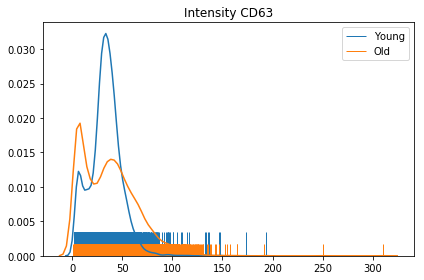

In [171]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 0
plt.figure()
sns.distplot(points_young[:,i],hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(points_old[:,i],hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title(labels[i])
plt.tight_layout()
plt.savefig('../generated_figures/cd63_rug_plt.eps', format='eps')
plt.show()


### Rug Plot of CD81

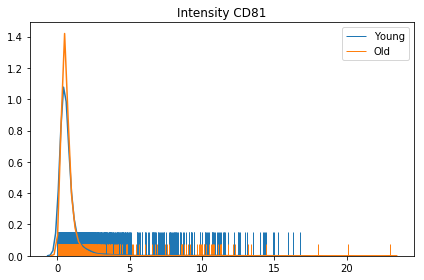

In [172]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 1
plt.figure()
sns.distplot(points_young[:,i],hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(points_old[:,i],hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title(labels[i])
plt.tight_layout()
p = plt.savefig('../generated_figures/cd81_rug_plt.eps', format='eps')
p = plt.show()

### Rug plot of KLotho

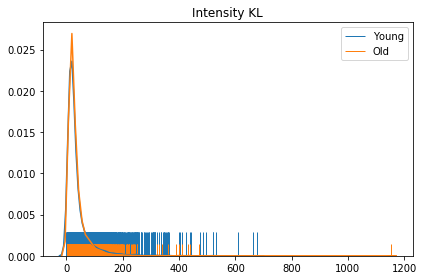

In [173]:
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Intensity AltKL', 'Size CD63', 'Size CD81', 'Size KL']
i = 1
fig = plt.figure()
sns.distplot(KL_intensities['Young'],hist=False,rug=True,rug_kws={'height':0.1})
sns.distplot(KL_intensities['Old'],hist=False,rug=True,rug_kws={'height':0.05})
plt.legend(['Young', 'Old'])
plt.title('Intensity KL')
plt.tight_layout()
plt.savefig('../generated_figures/KL_rug_plt.eps', format='eps')
plt.show()

## Fig. 3I: What features predict ch11 and ch4 activation? Both are Klotho but different forms of it. 

### Ch11

In [174]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = unfiltered_db.Intensity_MC_Ch11.to_numpy()
# Y = Y>0 # ch11> = 1, ch11< = 0
# print(np.count_nonzero(Y))
X = new_db.drop(['Class', 'Object Number',], axis=1)
# X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "Aspect Ratio_M02" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# Min Max scaler to normalize all data:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.to_numpy())
y_scaled = Y/np.linalg.norm(Y)
# train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
reg = LinearRegression()
sol = reg.fit(x_scaled,y_scaled)

# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
features = dict(zip(X.columns,sol.coef_))

# for i in range(0,X.shape[1]):
#     print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
#     features[X.columns[np.argmax(imp)]] = np.max(imp)
#     imp[np.argmax(imp)] = 0
for key,value in features.items():
    print(key + ' ' + '{:0.3f}'.format(value))
    
    
# Print the crossvalidation score:
s = cross_val_score(reg, x_scaled, y_scaled, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())

# df = pd.DataFrame(list(zip(values,names))).set_index(1)

# df.plot.line(rot=90)

features_2 = features

Feature Importances:
Aspect Ratio_M01 0.000
Intensity_MC_Ch07 0.001
Area_M09 -0.000
Aspect Ratio_M06 0.000
Area_M07 0.002
Area_M06 -0.001
Intensity_MC_Ch02 0.001
Area_M03 0.000
Area_M01 -0.001
Aspect Ratio_M09 0.000
Modulation_M07_Ch07 0.005
Modulation_M02_Ch02 0.005
Modulation_M03_Ch03 0.023
Cross-validation Score: -4.42608342377e-05
Cross-validation Score Var: 2.86043960912e-10


### Ch04 + Ch11

In [175]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = unfiltered_db.Intensity_MC_KL.to_numpy()
# Y = Y>0 # ch04> = 1, ch04< = 0
X = new_db.drop(['Class', 'Object Number',], axis=1)
# X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
# X = X.drop([i for i in X.columns if "01" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
# X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "04" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# # train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
# sol = clf.fit(X.to_numpy(),Y.astype('int'))

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X.to_numpy())
y_scaled = Y/np.linalg.norm(Y)
# Print out the feature importances
reg = LinearRegression()
sol = reg.fit(x_scaled,y_scaled)
# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = dict(zip(X.columns, sol.coef_))
for key,value in features.items():
    print(key + ' ' + '{:0.3f}'.format(value))

# for i in range(0,10):
#     print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
#     features[X.columns[np.argmax(imp)]] = np.max(imp)
#     imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, x_scaled, y_scaled,cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
# plt.figure()
# plt.bar(names, values)
# plt.xticks(rotation=90)
# plt.show()
# df = pd.DataFrame(list(zip(values,names))).set_index(1)

# df.plot.line(rot=90)
features_3 = features

Feature Importances:
Aspect Ratio_M01 0.000
Intensity_MC_Ch07 0.000
Area_M09 0.002
Aspect Ratio_M06 0.001
Area_M07 -0.001
Area_M06 -0.001
Intensity_MC_Ch02 0.001
Area_M03 -0.000
Area_M01 -0.001
Aspect Ratio_M09 0.000
Modulation_M07_Ch07 -0.002
Modulation_M02_Ch02 -0.009
Modulation_M03_Ch03 -0.006
Cross-validation Score: -4.5346970994e-05
Cross-validation Score Var: 2.43514311146e-10


## Fig. 3J: Correlation between ch7 and ch11. 

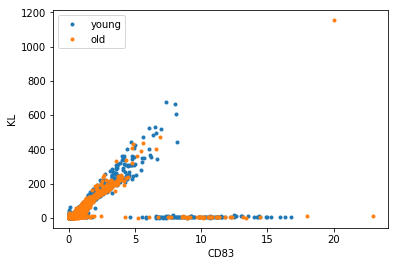

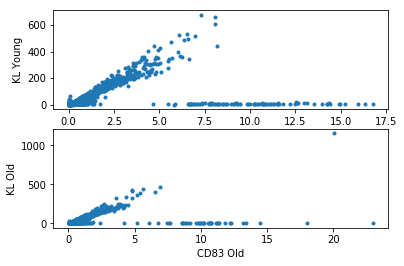

Young Pearson's correlation coefficient
[[ 1.          0.42323693]
 [ 0.42323693  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.47261576]
 [ 0.47261576  1.        ]]


In [176]:
new_db = unfiltered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_kl_intensity = new_db[(new_db.Class==1)].Intensity_MC_KL
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_kl_intensity = new_db[(new_db.Class==0)].Intensity_MC_KL

plt.plot(young_ch7_intensity, young_kl_intensity, '.')
plt.plot(old_ch7_intensity, old_kl_intensity,'.')
plt.legend(['young', 'old'])
plt.xlabel('CD83')
plt.ylabel('KL')
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_kl_intensity, '.')
plt.xlabel('CD83 Young')
plt.ylabel('KL Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_kl_intensity,'.')
plt.xlabel('CD83 Old')
plt.ylabel('KL Old')
# plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_kl_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_kl_intensity))


### Fig. 3K: Heat map for classifiers

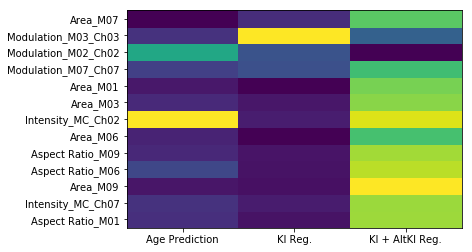

,Age Prediction,Kl Reg.,Kl + AltKl Reg.
Features,,,
Aspect Ratio_M01,0.133771,0.048605,0.853611
Intensity_MC_Ch07,0.141383,0.077436,0.850888
Area_M09,0.057493,0.042531,1.000000
Aspect Ratio_M06,0.213512,0.048864,0.896423
Aspect Ratio_M09,0.113272,0.051690,0.861744
Area_M06,0.096245,0.003563,0.705206
Intensity_MC_Ch02,1.000000,0.079775,0.949174
Area_M03,0.116888,0.061250,0.820799
Area_M01,0.063691,0.000000,0.794738


In [184]:
heat_map = pd.DataFrame.from_dict(features_1, orient='index', columns=['Age Prediction'])
heat_map.index.name = 'Features'
heat_map['Kl Reg.'] = heat_map.index.map(features_2)
heat_map['Kl + AltKl Reg.'] = heat_map.index.map(features_3)

heat_map = heat_map.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)

plt.figure()
plt.pcolor(heat_map)
plt.yticks(np.arange(0.5, len(heat_map.index), 1), heat_map.index)
plt.xticks(np.arange(0.5, len(heat_map.columns), 1), heat_map.columns)
plt.savefig('../generated_figures/heat_map.eps',format='eps')
plt.show()
heat_map